In [1]:
from endogen.endogen import EndogenousSystem
from endogen.config import GlobalSimConfig, InputModel, Lags

from dataclasses import asdict
import hydra
from hydra.utils import instantiate

from mlforecast.forecast import MLForecast
from sklearn.linear_model import LinearRegression

# Minimal example without using configuration files

In [19]:
gc = GlobalSimConfig(input_data = "data/cy_data_static_test.csv",
                     time_var = "year",
                     unit_var = "gwcode",
                     nsim = 10,
                     end = 2050,
                     include_past_n = 30,
                     start = 2015,
                     vars = ['gdppc', 'psecprop'])

gdppc_model = InputModel(stage = "writing",
           output_var= "gdppc",
           input_vars = ["gdppc_l1", "psecprop_l1"],
           model = MLForecast(models = LinearRegression()),
           lags = [Lags(num_lag = 1, input_vars = ["gdppc", "psecprop"])])

edu_model = InputModel(stage = "writing",
           output_var= "psecprop",
           input_vars = ["gdppc_l1", "psecprop_l1"],
           model = MLForecast(models = LinearRegression()),
           lags = [Lags(num_lag = 1, input_vars = ["gdppc", "psecprop"])])

s = EndogenousSystem(**asdict(gc))
s.models.add_models([gdppc_model, edu_model])
s.create_forecast_container()
s.fit_models()
s.simulate()

The following units were removed to attain a balanced dataset over 31 years: {520, 940, 692, 701, 317, 702, 703, 705, 341, 343, 344, 346, 860, 349, 359, 366, 367, 368, 369, 370, 371, 372, 373}.


## Plot results

In [ ]:
s.plot("gdppc", unit = 475)
s.plot("psecprop", unit = 475)

## A graph representation of the model system

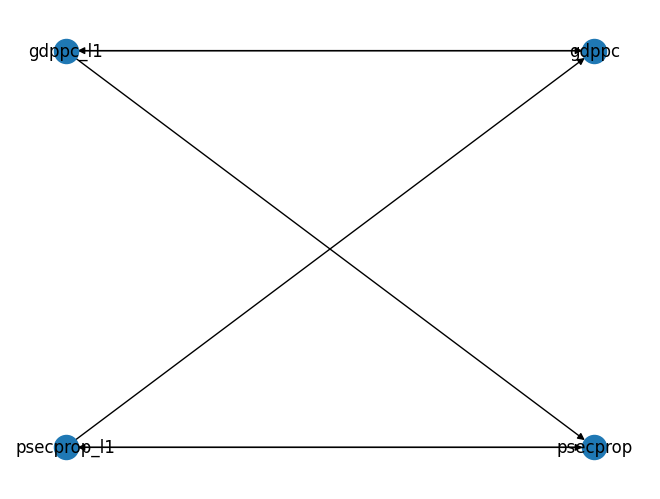

In [3]:
s.models.plot()

# A more expansive example using configuration files

Here we use the configuration files found in the "conf" sub-folder. The conf/config.yaml points to .yaml files in conf/global_config and conf/variables. We load these files with hydra. When instantiating, the configuration is made into Python classes defined in endogen/config.py. These are helpers that make it easier to set up our system of endogenous variables.

In [20]:
with hydra.initialize(version_base = "1.3", config_path="conf"):
    config = hydra.compose(config_name = "config")
    config = instantiate(config, _convert_="all")

In [21]:
s = EndogenousSystem(**asdict(config.global_config))
s.models.add_models(config.variables)
s.create_forecast_container()

The following units were removed to attain a balanced dataset over 31 years: {704, 705, 520, 522, 910, 341, 343, 344, 346, 860, 620, 940, 435, 692, 53, 317}.


The model scheduler uses the graph representation of our endogenous system, breaks it down into a tranformation step and a forecast step, and determines the sequence calculations must be done. It returns a list of lists that the system then can iterate over. The scheduler is baked into the simulation system, and you do not need to interact with this yourself.

In [22]:
t0, t1 = s.models._model_schedule
t0, t1

(ModelSchedule(delta_t=0, schedule=[['gdppc_l1', 'grwth_rm4', 'intensity_level_hlm8', 'psecprop_l1', 'intensity_level_l1', 'v2x_libdem_l1', 'population_l1', 'rgdp_rank', 'v2x_libdem_rm8'], ['grwth_rm4_l1', 'intensity_level_hlm8_l1', 'rgdp_rank_l1', 'v2x_libdem_rm8_l1']]),
 ModelSchedule(delta_t=1, schedule=[['grwth', 'intensity_level', 'psecprop', 'v2x_libdem', 'population'], ['gdppc'], ['rgdp']]))

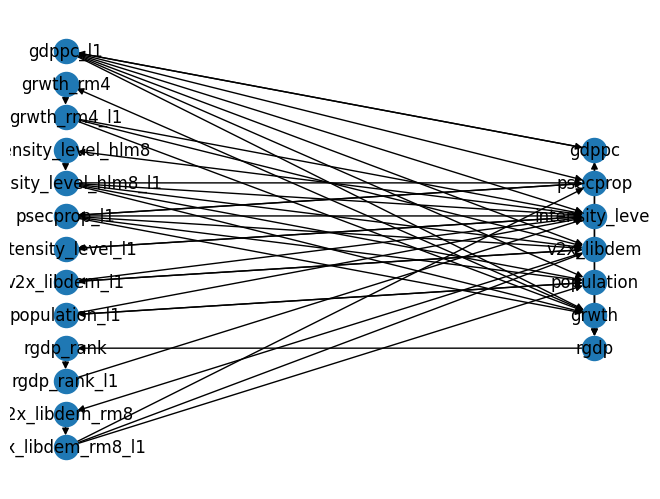

In [18]:
s.models.plot()

In [9]:
s.fit_models()

In [10]:
s.simulate()

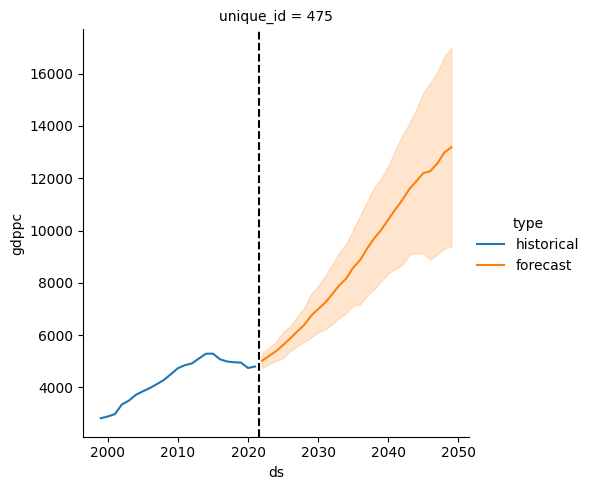

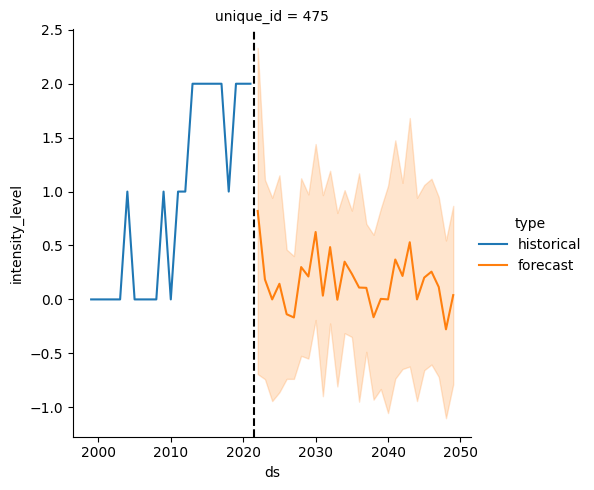

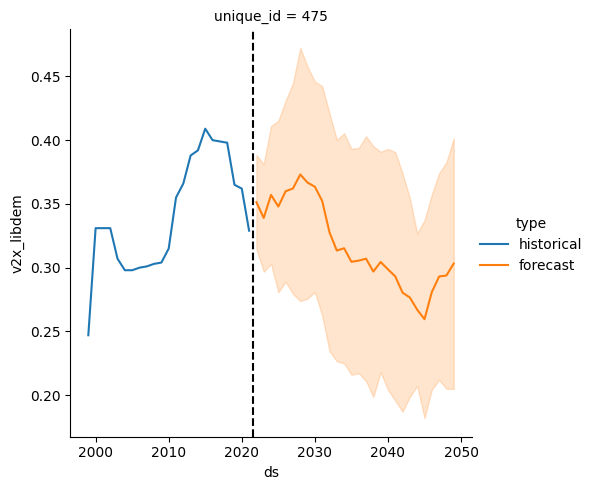

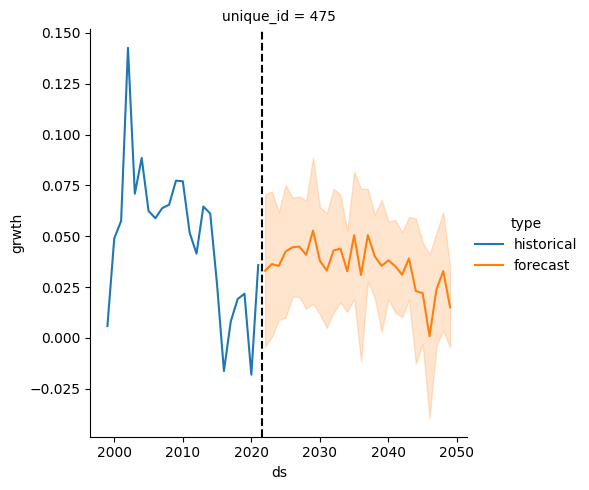

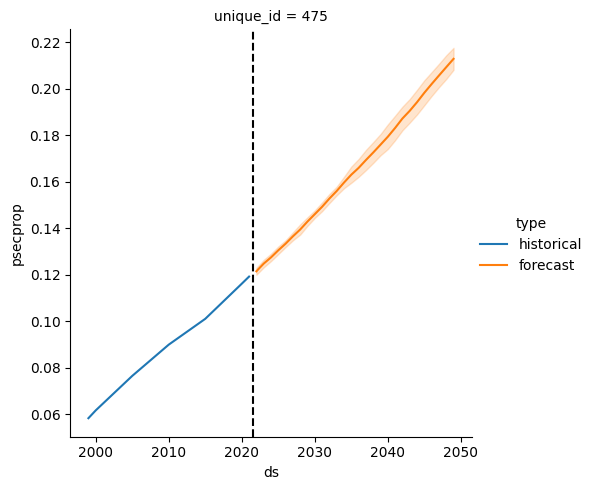

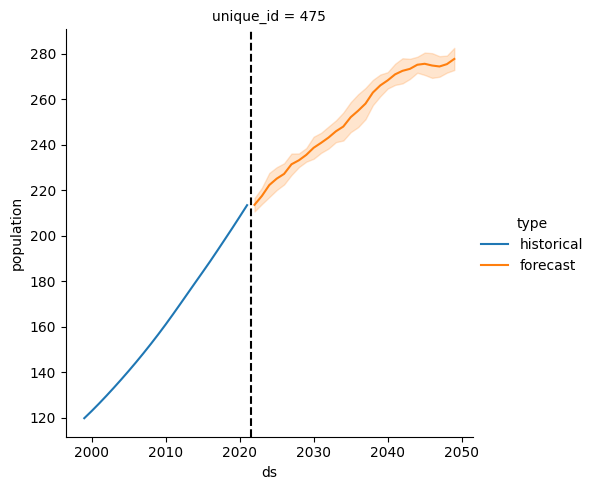

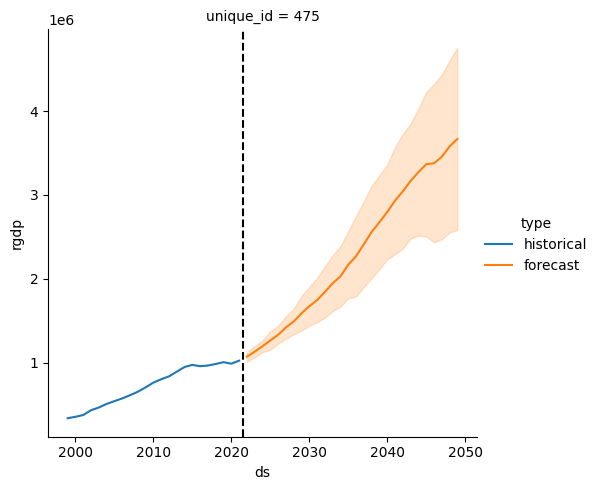

In [17]:
s.plot("gdppc", unit = 475)
s.plot("intensity_level", unit = 475)
s.plot("v2x_libdem", unit = 475)
s.plot("grwth", unit = 475)
s.plot("psecprop", unit = 475)
s.plot("population", unit = 475)
s.plot("rgdp", unit = 475)